In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import cv2
import numpy as np
from torch.autograd import Variable

from IPython.display import Image as DisplayImage, display
from PIL import Image  


In [3]:
# Load MNIST as tensor (no normalization yet)
raw_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

loader = DataLoader(raw_dataset, batch_size=100, shuffle=False)

# Compute mean and std
mean = 0.0
std = 0.0
num_batches = 0

for images, _ in loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, -1)
    mean += images.mean(1).sum()
    std += images.std(1).sum()
    num_batches += batch_samples

mean_gray = mean / num_batches
std_gray = std / num_batches

print(f"Mean: {mean_gray.item():.4f}, Std: {std_gray.item():.4f}")

Mean: 0.1307, Std: 0.3015


In [4]:
# Define the transform pipeline
# Define Transform, Load Datasets and DataLoaders
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean_gray.item(),), (std_gray.item(),))
])

train_dataset = datasets.MNIST(root="./data", 
                               train=True, 
                               transform=transform,
                               download = True)

test_dataset = datasets.MNIST(root="./data", 
                               train=False, 
                               transform=transform)

batch_size = 100
train_load = torch.utils.data.DataLoader(dataset=train_dataset, batch_size = batch_size, shuffle=True)
test_load = torch.utils.data.DataLoader(dataset=test_dataset, batch_size = batch_size, shuffle=False)

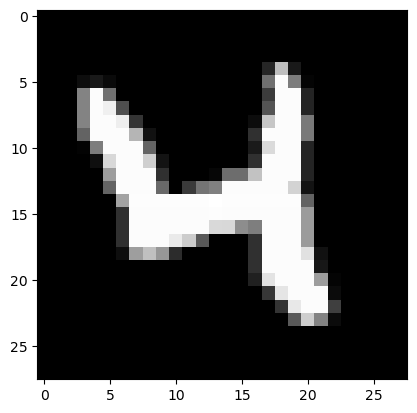

In [5]:
random_img = train_dataset[20][0].numpy() * std_gray.item() + mean_gray.item() # shape: (1, 28, 28)
plt.imshow(random_img.reshape(28,28), cmap="gray")

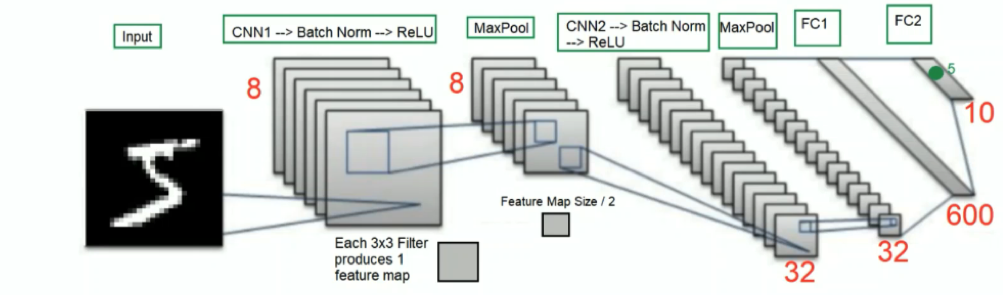

In [6]:
display(DisplayImage(filename="images/cnn_structure.png"))

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        # Same padding: input size = output size
        # Same padding: (filter size - 1) / 2 -> (3-1)/2 = 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding = 1)
        # The output size of each of the 8 feature maps: ((input size - filter size + 2 * padding)/stride) + 1 = (28 - 3 + 2)/1 + 1 = 28
        self.batchnorm1 = nn.BatchNorm2d(8)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        # Output size: 28/2 = 14
        # Same Padding: (5-1)/2 = 2
        self.cnn2 = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=5, stride=1, padding = 2)
        # The output size of each of the 32 feature maps: (14 - 5 + 2*2)/1 + 1 = 14
        self.batchnorm2 = nn.BatchNorm2d(32)
        # Flatten the 32 feature maps: 7*7*32 = 1568
        self.fc1 = nn.Linear(1568, 600)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(600, 10)
        
    def forward(self, x):
        out = self.cnn1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.cnn2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = out.view(out.size(0), -1)  # Flatten

        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)

        return out

In [8]:
torch.cuda.is_available()

False

In [9]:
mps_device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

mps_device 

device(type='mps')

In [10]:
model = CNN().to(mps_device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

In [11]:
# What's happening
iteration = 0
correct = 0

for i, (inputs, labels) in enumerate(train_load):
    inputs = inputs.to("mps")
    labels = labels.to("mps")

    print("For one iteration, this is what happens: ")
    print("Input shape:", inputs.shape)
    print("Labels shape:", labels.shape)
    output = model(inputs)
    print("Output shape:", output.shape)
    _, predicted = torch.max(output, 1) #_ means the max scores. We don't use it here
    print("Predicted shape", predicted.shape)
    print("Predicted tensor:", predicted)
    correct += (predicted==labels).sum()
    break

For one iteration, this is what happens: 
Input shape: torch.Size([100, 1, 28, 28])
Labels shape: torch.Size([100])
Output shape: torch.Size([100, 10])
Predicted shape torch.Size([100])
Predicted tensor: tensor([7, 1, 3, 1, 8, 6, 6, 1, 4, 1, 4, 4, 1, 3, 6, 4, 4, 4, 4, 7, 1, 1, 4, 4,
        2, 7, 4, 4, 6, 2, 6, 1, 4, 9, 4, 4, 6, 6, 1, 6, 1, 8, 1, 4, 8, 6, 1, 7,
        2, 4, 7, 7, 1, 1, 6, 0, 7, 7, 4, 7, 7, 1, 6, 1, 1, 4, 4, 7, 6, 4, 1, 1,
        8, 3, 4, 0, 4, 9, 1, 4, 2, 4, 3, 8, 1, 7, 9, 3, 4, 4, 4, 4, 4, 6, 7, 1,
        1, 1, 4, 5], device='mps:0')


In [79]:
num_epochs = 50
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    correct = 0
    iterations = 0
    iter_loss = 0.0

    model.train()

    for i, (inputs, labels) in enumerate(train_load):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        iter_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted==labels).sum().item()
        iterations += 1

    train_loss.append(iter_loss/iterations)
    train_accuracy.append(100 * correct / len(train_dataset))

    # Test phase
    model.eval()
    
    correct = 0
    iterations = 0
    iter_loss = 0.0

    with torch.no_grad():
    # no gradients will be tracked here
        for i, (inputs, labels) in enumerate(test_load):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            iter_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted==labels).sum().item()
            iterations += 1

        test_loss.append(iter_loss/iterations)
        test_accuracy.append(100 * correct / len(test_dataset))

    
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss[-1]:.3f}, Train Accuracy: {train_accuracy[-1]:.2f}%, "
          f"Test Loss: {test_loss[-1]:.3f}, Test Accuracy: {test_accuracy[-1]:.2f}%")

Epoch 1/50, Train Loss: 0.042, Train Accuracy: 98.91%, Test Loss: 0.070, Test Accuracy: 98.96%
Epoch 2/50, Train Loss: 0.042, Train Accuracy: 98.88%, Test Loss: 0.055, Test Accuracy: 99.08%
Epoch 3/50, Train Loss: 0.044, Train Accuracy: 98.83%, Test Loss: 0.056, Test Accuracy: 98.84%
Epoch 4/50, Train Loss: 0.040, Train Accuracy: 98.89%, Test Loss: 0.065, Test Accuracy: 98.98%
Epoch 5/50, Train Loss: 0.046, Train Accuracy: 98.89%, Test Loss: 0.056, Test Accuracy: 98.90%
Epoch 6/50, Train Loss: 0.047, Train Accuracy: 98.79%, Test Loss: 0.069, Test Accuracy: 98.95%
Epoch 7/50, Train Loss: 0.040, Train Accuracy: 98.99%, Test Loss: 0.076, Test Accuracy: 98.89%
Epoch 8/50, Train Loss: 0.037, Train Accuracy: 99.03%, Test Loss: 0.067, Test Accuracy: 98.89%
Epoch 9/50, Train Loss: 0.045, Train Accuracy: 98.94%, Test Loss: 0.060, Test Accuracy: 99.04%
Epoch 10/50, Train Loss: 0.039, Train Accuracy: 98.99%, Test Loss: 0.057, Test Accuracy: 99.02%
Epoch 11/50, Train Loss: 0.036, Train Accuracy: 9

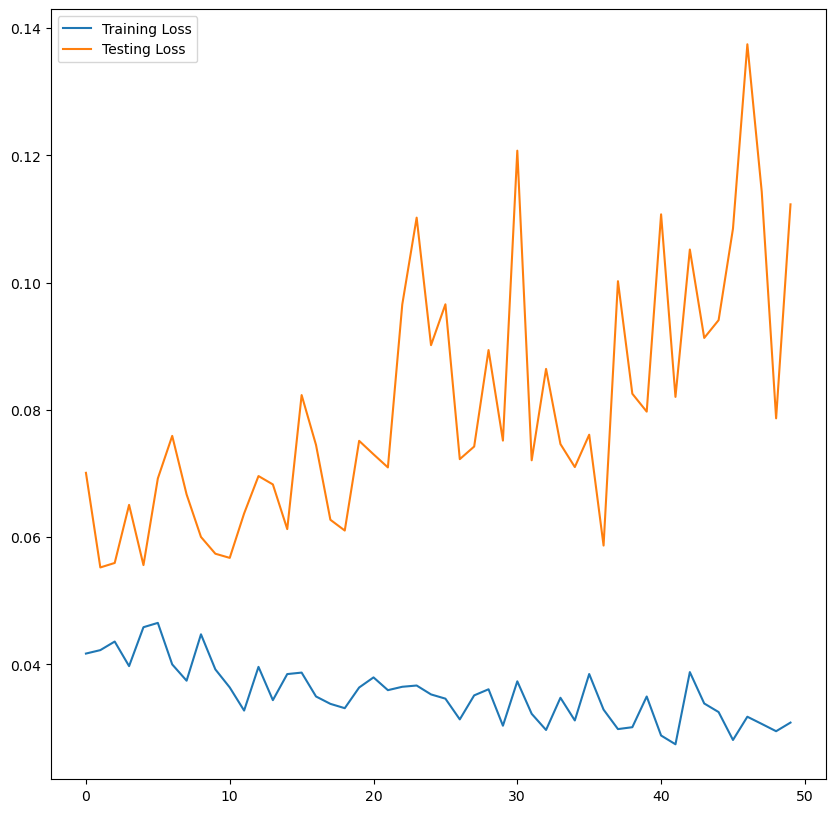

In [80]:
# Plot the loss
f = plt.figure(figsize = (10,10))
plt.plot(train_loss, label = "Training Loss")
plt.plot(test_loss, label = "Testing Loss")
plt.legend()
plt.show()

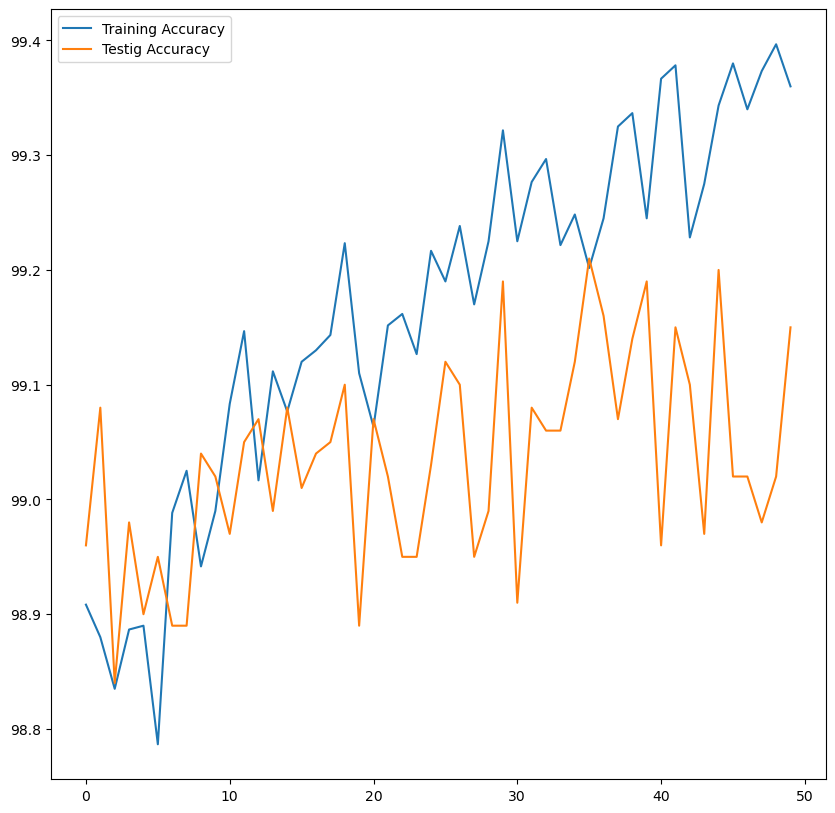

In [81]:
# Plot the accuracy
f = plt.figure(figsize = (10,10))
plt.plot(train_accuracy, label = "Training Accuracy")
plt.plot(test_accuracy, label = "Testig Accuracy")
plt.legend()
plt.show()

In [82]:
# Random image prediction
img = test_dataset[30][0].resize_((1,1,28,28)) # [batch_size, channels, height, width]
label = test_dataset[30][1]

model.eval()

img = img.to(device)

outputs = model(img)
_, predicted = torch.max(outputs, 1)
print("Predicted is: {}".format(predicted.item()))
print("Actual is: {}".format(label))

Predicted is: 3
Actual is: 3


In [137]:
# Predict an image I wrote
image = Image.open("images/IMG3.jpg") # Convert to grayscale
image_pil = image.convert("L")

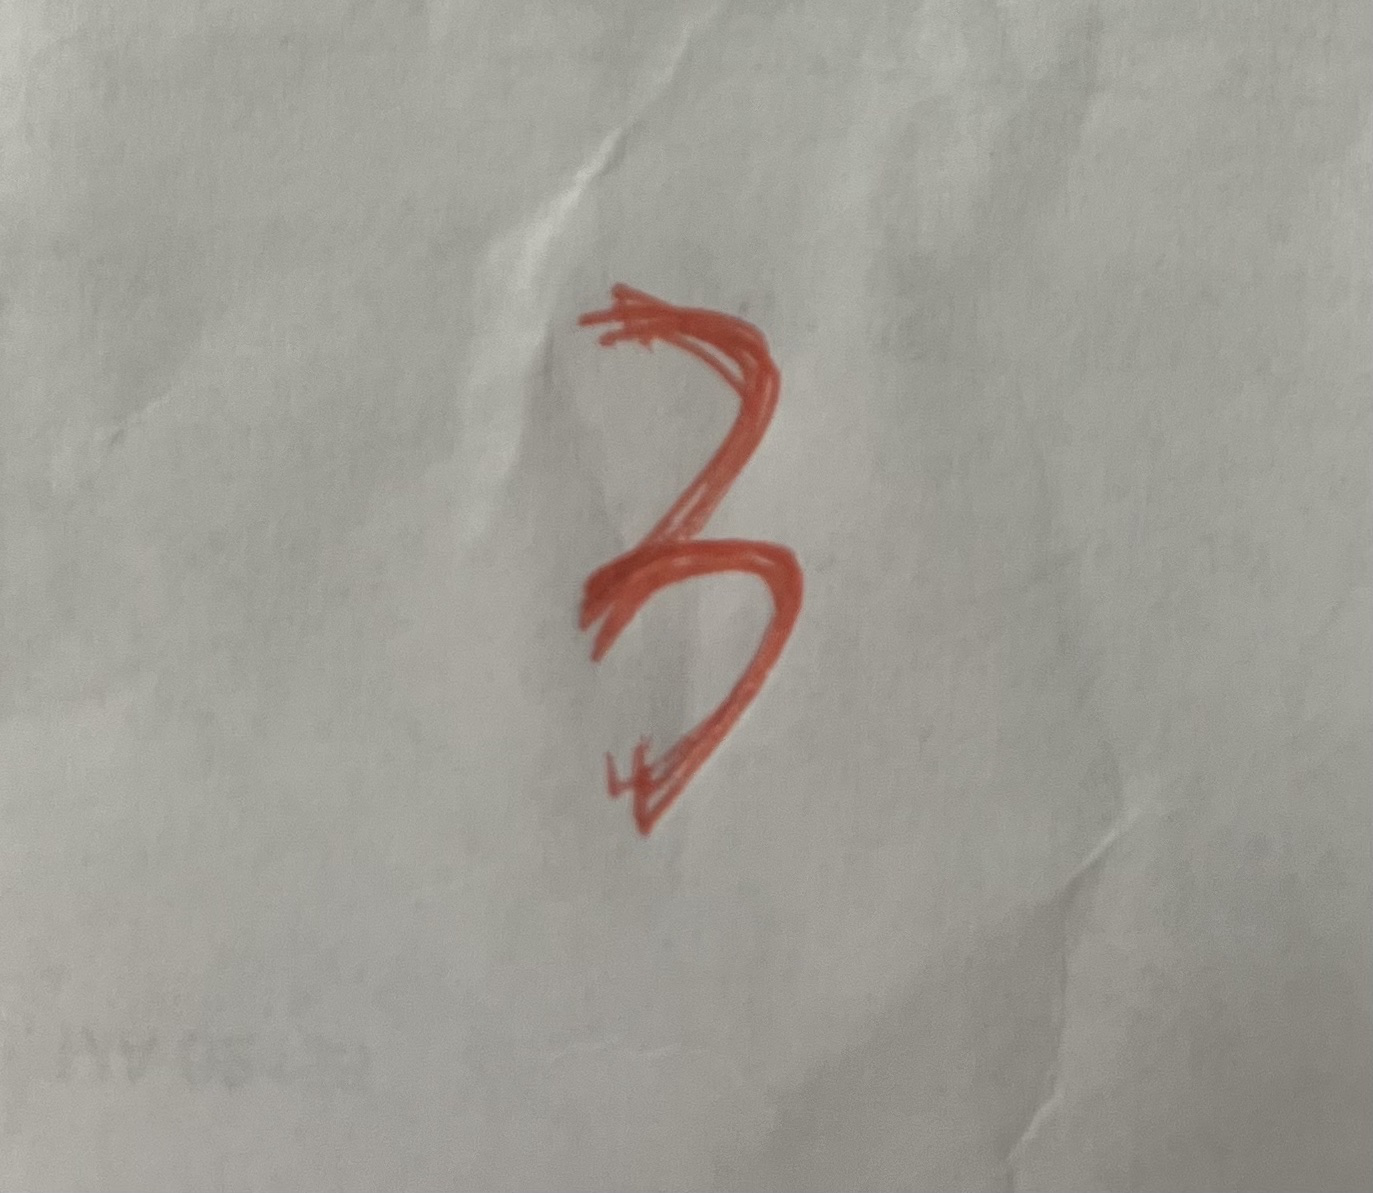

In [139]:
image

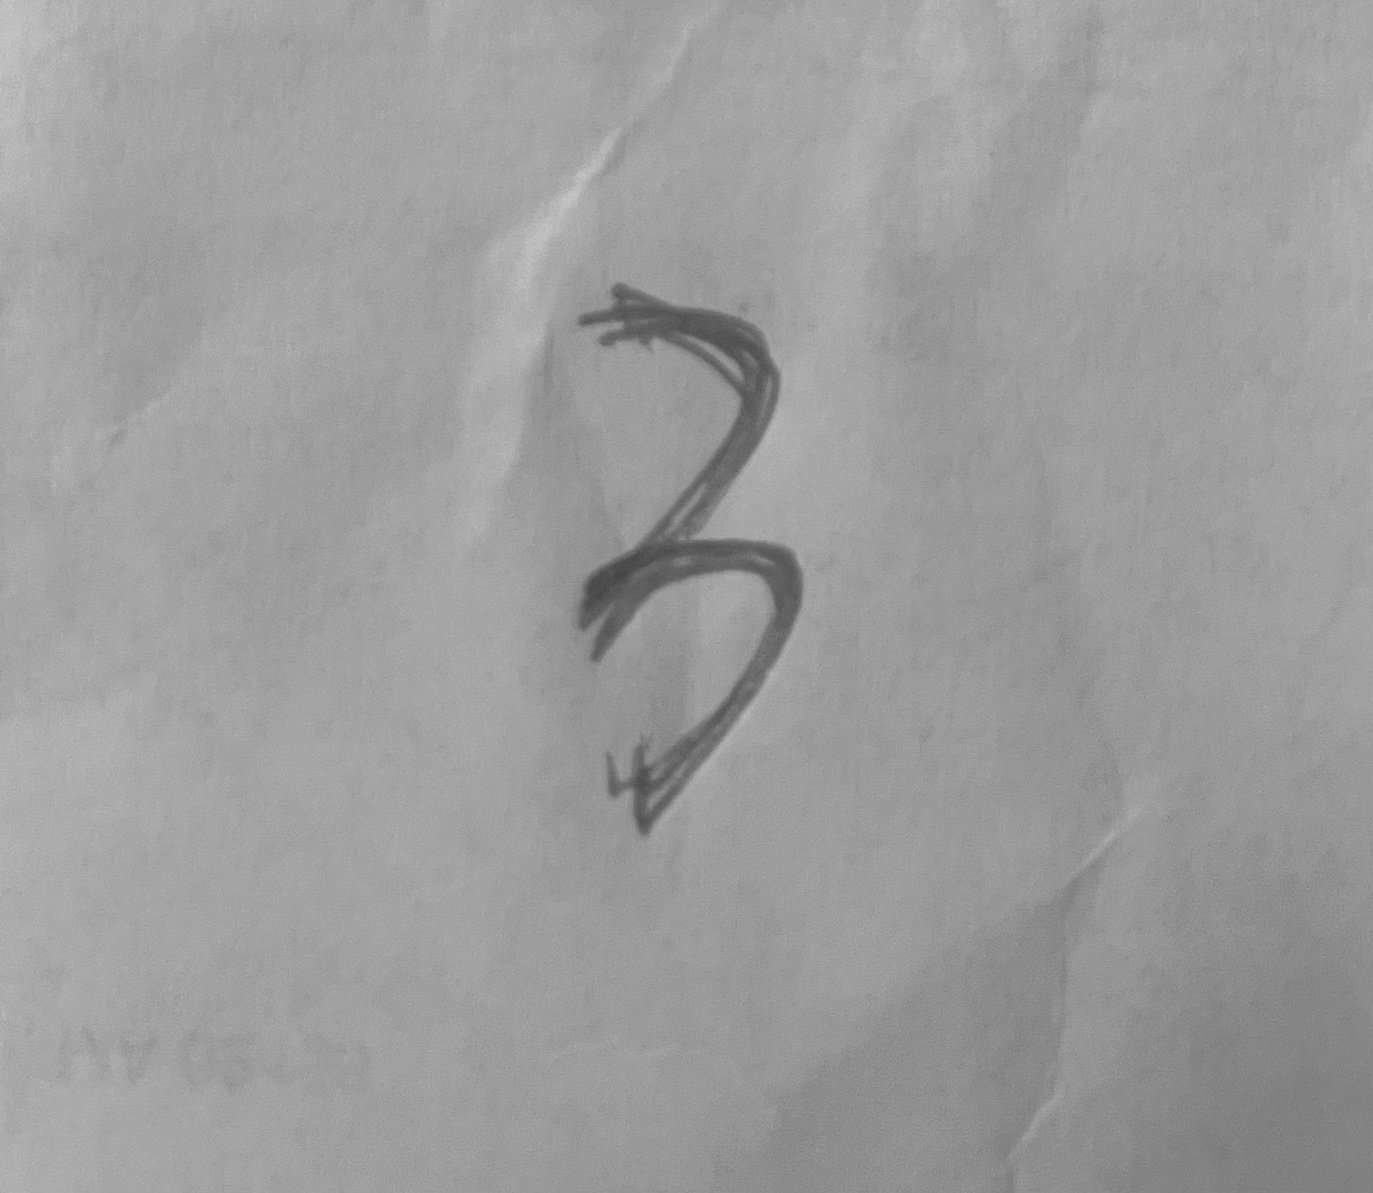

In [141]:
image_pil

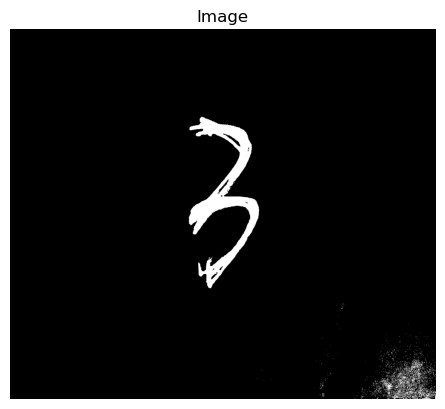

In [143]:
image_np = np.array(image_pil)
ret, thresholded = cv2.threshold(image_np, 127, 255, cv2.THRESH_BINARY)
image_np = 255 - thresholded

plt.imshow(image_np, cmap='gray')
plt.axis('off')
plt.title("Image")
plt.show()

In [145]:
print(np.min(image_np), np.max(image_np))

0 255


In [147]:
# Dict to hold intermediate outputs


def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook


def plot_feature_maps(layer_name, num_maps=8):
    feature_maps = activations[layer_name].squeeze(0)  # remove batch dim
    num_maps = min(num_maps, feature_maps.shape[0])
    
    plt.figure(figsize=(15, 5))
    for i in range(num_maps):
        plt.subplot(1, num_maps, i+1)
        plt.imshow(feature_maps[i].cpu(), cmap='gray')
        plt.axis('off')
        plt.title(f'{layer_name} - Map {i}')
    plt.show()


Predicted digit: 3


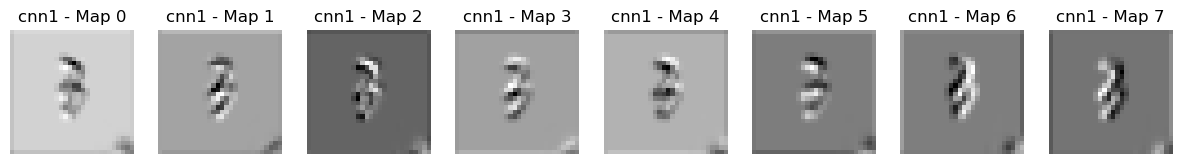

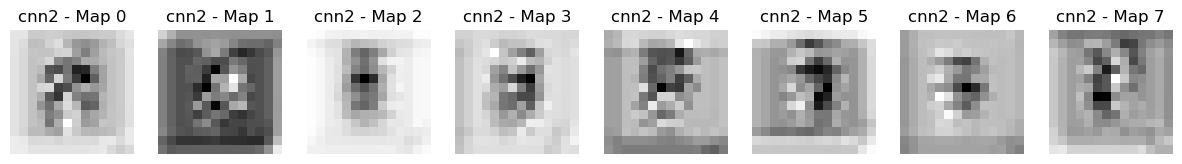

In [149]:
activations = {}

transform = transforms.Compose([
    transforms.Resize((28,28)), 
    transforms.ToTensor(),
    transforms.Normalize((mean_gray.item(),), (std_gray.item(),))
])

img = Image.fromarray(image_np)
img = transform(img).unsqueeze(0).to(device) 

model.to(device)
model.eval()

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
img = img.to(device)

# Register hooks ONCE

model.cnn1.register_forward_hook(get_activation('cnn1'))
model.cnn2.register_forward_hook(get_activation('cnn2'))

            
with torch.no_grad():
    output = model(img)
    _, predicted = torch.max(output, 1)

print(f"Predicted digit: {predicted.item()}")

# Plot features from first and second conv layer
plot_feature_maps('cnn1', num_maps=8)
plot_feature_maps('cnn2', num_maps=8)


In [151]:
model


CNN(
  (cnn1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(8, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1568, out_features=600, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=600, out_features=10, bias=True)
)